In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap, lax, grad, config, jacfwd
import equinox as eqx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

from JaxCMB import main, cosmology, cosmology2
from JaxCMB import constants as cnst
from JaxCMB.hyrax import hyrax

# Inputs

To create and call methods from a background objects, we at least need a list of model specific fluids, and the cosmological parameters of the current computation.

Here is a run with LCDM+massive Nu's, assuming standard cosmological parameters.

In [3]:
model = main.Model(ellmin=180, ellmax=220, has_MasslessNeutrinos=False, has_MassiveNeutrinos=False)

In [8]:
params = {
    'h': 0.6762,
    'omega_cdm': 0.1193,
    'omega_b': 0.0225,
    'A_s': 2.12424e-9,
    'n_s': 0.9709,
    'Neff': 0.,
    'YHe': 0.247,
    'TCMB0': 2.34865418e-4,
    'T_nu': (4. / 11.)**(1. / 3.) * 2.34865418e-4,
    'N_ncdm': 0,
    'T_ncdm': 0.71611 * 2.34865418e-4,
    'm_ncdm': 0.06,
}

Now jit over a function that creates a BG module

In [9]:
def f1(params):
    params = model.add_derived_parameters(params)
    BG = cosmology.Background(params, model.species_list, model.RM)
    return BG

def f2(params):
    params = model.add_derived_parameters(params)
    BG = cosmology2.Background(params, model.species_list, model.RM)
    return BG

In [10]:
j1 = eqx.filter_jit(f1)
j2 = eqx.filter_jit(f2)

In [11]:
for i in range(3):
    s = time.time()
    BG1 = j1(params)
    BG1.tau_tab.block_until_ready()
    print(time.time() - s)

for i in range(3):
    s = time.time()
    BG2 = j2(params)
    BG2.tau_tab.block_until_ready()
    print(time.time() - s)

/ext3/miniconda3/lib/python3.10/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)
/ext3/miniconda3/lib/python3.10/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)


39.59874391555786
0.23232507705688477
0.23114323616027832


/ext3/miniconda3/lib/python3.10/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)
/ext3/miniconda3/lib/python3.10/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)


41.44736289978027
0.23584198951721191
0.2370154857635498


In [27]:
def f1(params):
    params = model.add_derived_parameters(params)
    BG = cosmology.Background(params, model.species_list, model.RM)
    return BG

Array([3.56046874e+08, 3.54873738e+08, 3.53704468e+08, ...,
       2.24766169e-04, 2.25159620e-04, 2.25556135e-04], dtype=float64)

# Comparison to HYREC

In [10]:
hyrec_full = np.loadtxt("/home/zz1994/packages/HYREC-2/ABCMB_test_FULL.dat")
hyrec_swift = np.loadtxt("/home/zz1994/packages/HYREC-2/ABCMB_test_SWIFT.dat")

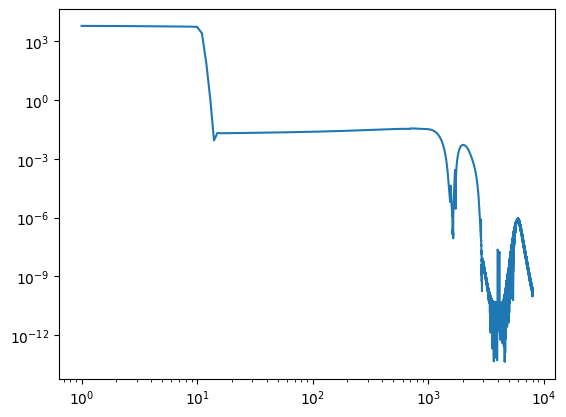

In [31]:
hyrec = hyrec_full
z_hyrec = hyrec[:, 0]
xe_hyrec = hyrec[:, 1]
Tm_hyrec = hyrec[:, 2]*cnst.kB
lna = -jnp.log(1.+z_hyrec)
xe_ABCMB = BG.xe(lna)

#plt.plot(z_hyrec, abs(xe_ABCMB-xe_hyrec)/xe_hyrec)
plt.plot(z_hyrec, abs(xe_ABCMB-xe_hyrec)/xe_hyrec)
#plt.xlim((-9, -5))
#plt.ylim((1.e-12, 1))
plt.yscale("log")
plt.xscale("log")
plt.show()

# Saving Output

In [35]:
arr = np.array(list(params.items()), dtype=object)
np.savetxt("params.txt", arr, fmt="%s")
np.savez(
    "background.npz",
    tau_tab=np.array(BG.tau_tab),
    H_tab=np.array(BG.H(BG.lna_tau_tab)),
    xe_tab=np.array(BG.xe_tab.arr),
    lna_xe_tab=np.array(BG.lna_xe_tab.arr),
    Tm_tab=np.array(BG.Tm_tab.arr),
    lna_Tm_tab=np.array(BG.lna_Tm_tab.arr),
    kappa_tab=np.array(BG.kappa(BG.lna_tau_tab)),
)

# Comparing to CLASS

In [44]:
BG = cosmology.ClassBackground()

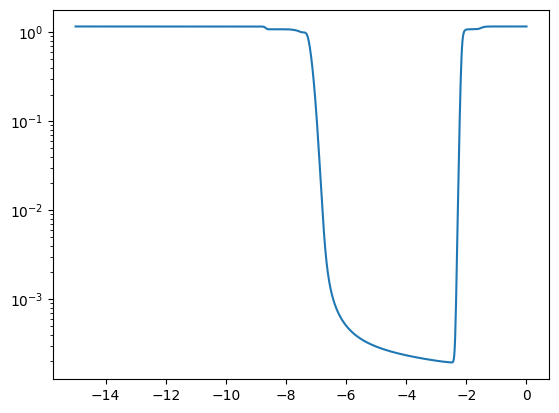

In [45]:
lna = jnp.linspace(-15.0, 0.0, 1000)
plt.plot(lna, BG.xe(lna))
plt.yscale("log")
plt.show()

In [46]:
path = "/home/zz1994/packages/class/output/ABCMB_test"
bg_class = np.loadtxt(path+"/noneutrinos00_background.dat")
thermo_class = np.loadtxt(path+"/noneutrinos00_thermodynamics.dat")

### Hubble

In [47]:
a = 1/(1.+bg_class[:, 0])
H_class = bg_class[:, 3] * cnst.c_Mpc_over_s
H_ABCMB = BG.H(jnp.log(a))

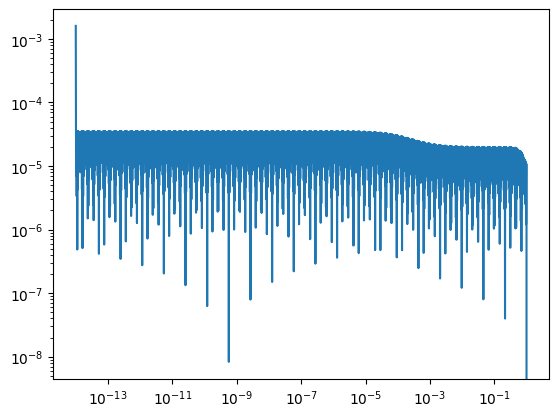

In [48]:
plt.loglog(a, abs(H_class - H_ABCMB)/H_class)
#plt.xlim((1.e-10, 0.))
plt.show()

### Conformal Time

In [49]:
a = 1/(1.+bg_class[:, 0])
tau_class = bg_class[:, 2]
tau_ABCMB = BG.tau(jnp.log(a))

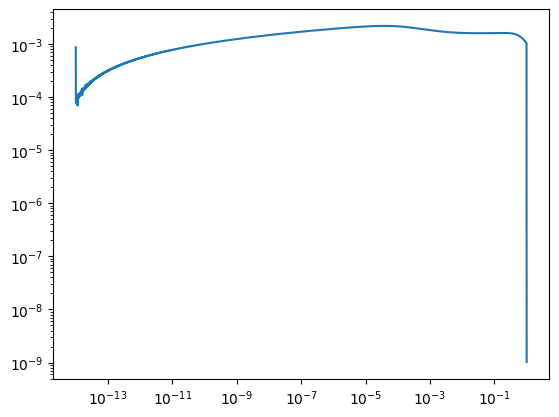

In [50]:
plt.loglog(a, abs(tau_class - tau_ABCMB)/tau_class)
#plt.xlim((1.e-10, 0.))
plt.show()

### xe, Tm

In [51]:
a = thermo_class[:, 0]
xe_class = thermo_class[:, 3]
Tm_class = thermo_class[:, 7]
xe_abcmb = BG.xe(jnp.log(a))
Tm_abcmb = BG.Tm(jnp.log(a)) / cnst.kB

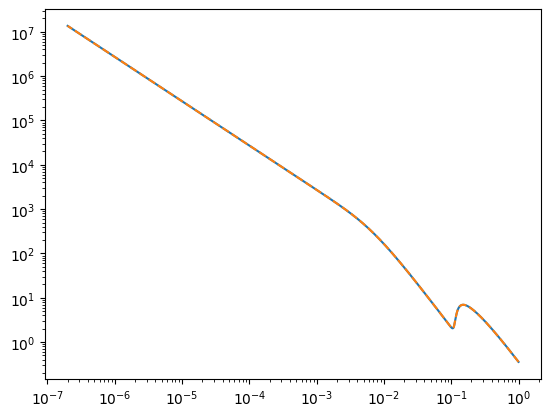

In [52]:
plt.loglog(a, Tm_class)
plt.loglog(a, Tm_abcmb, "--")
plt.show()

/state/partition1/job-296194/ipykernel_628462/4146330351.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


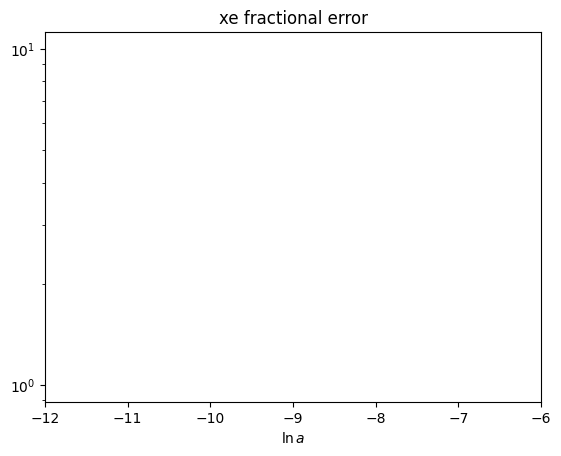

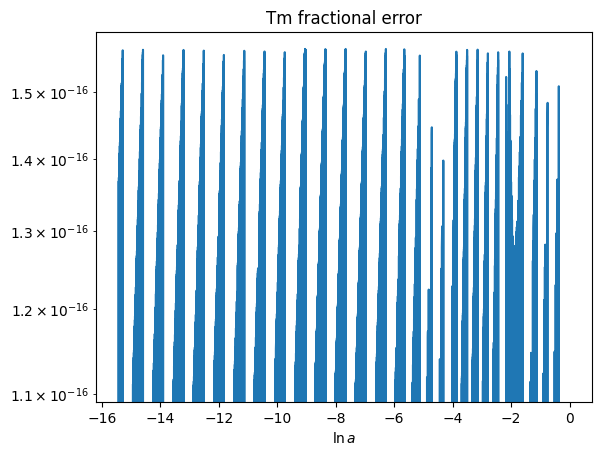

In [53]:
plt.plot(jnp.log(a), abs(xe_abcmb-xe_class)/xe_class)
plt.yscale("log")
plt.xlabel(r"$\ln{a}$")
plt.title("xe fractional error")
plt.xlim((-12, -6))
plt.show()

plt.plot(jnp.log(a), abs(Tm_abcmb-Tm_class)/Tm_class)
plt.yscale("log")
plt.xlabel(r"$\ln{a}$")
plt.title("Tm fractional error")
plt.show()

### Scattering Rate

In [54]:
a = thermo_class[:, 0]
tauc_class = 1/thermo_class[:, 4]
tauc_abcmb = BG.tau_c(jnp.log(a))

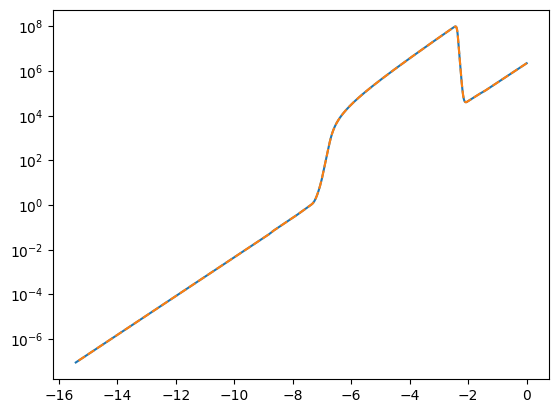

In [55]:
plt.plot(jnp.log(a), tauc_class)
plt.plot(jnp.log(a), tauc_abcmb, "--")
plt.yscale("log")
plt.show()

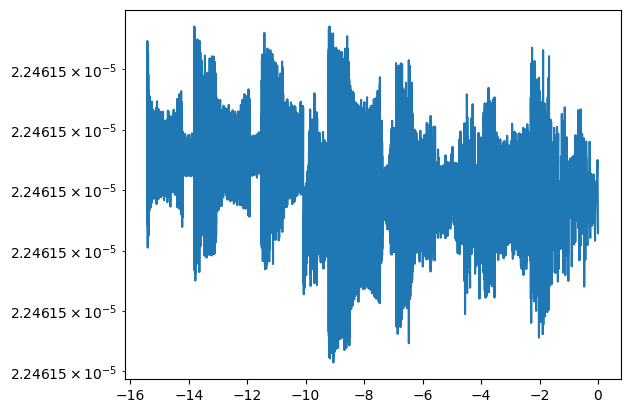

In [56]:
plt.plot(jnp.log(a), abs(tauc_abcmb-tauc_class)/tauc_class)
plt.yscale("log")
plt.show()

### Optical depth

In [57]:
a = thermo_class[:, 0]
kappa_class = -jnp.log(thermo_class[:, 5])
kappa_abcmb = BG.kappa(jnp.log(a))

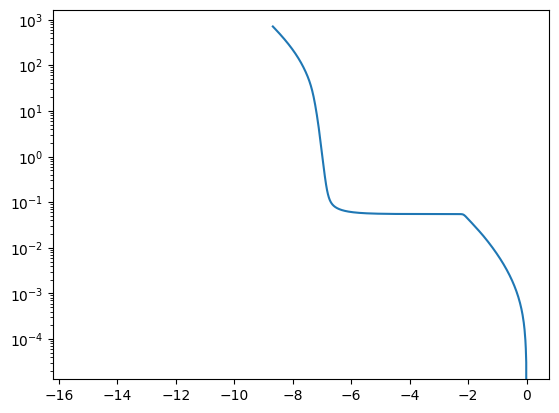

In [58]:
plt.plot(jnp.log(a), kappa_class)
plt.plot(jnp.log(a), kappa_abcmb, "--")
plt.yscale("log")
plt.show()

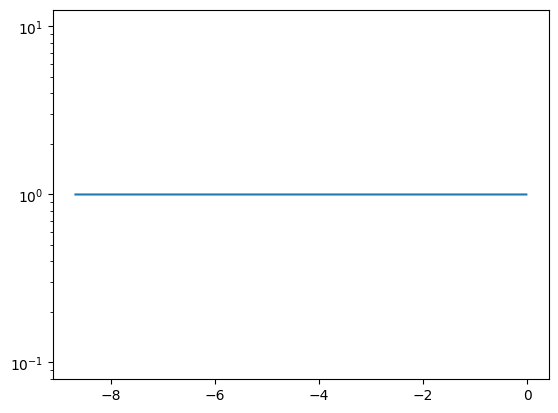

In [59]:
plt.plot(jnp.log(a), abs(kappa_abcmb-kappa_class)/kappa_class)
plt.yscale("log")
plt.show()

# Reading Result from CLASS

In [11]:
class_res_dir = "/home/zz1994/packages/class/output/ABCMB_test/noneutrinos00"
bac = np.loadtxt(class_res_dir+"_background.dat")
therm = np.loadtxt(class_res_dir+"_thermodynamics.dat")

In [13]:
bac[:, 4]

array([14248.53227261, 14248.53227261, 14248.53227261, ...,
          95.85369363,    47.79180017,     0.        ], shape=(3000,))

In [16]:
BG = cosmology.ClassBackground()

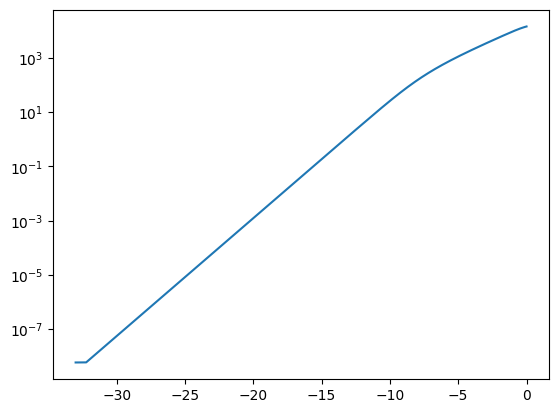

In [20]:
plt.plot(BG.lna_tau_tab, BG.tau_tab)
plt.yscale("log")

In [21]:
BG.params

{np.str_('h'): 0.6762,
 np.str_('omega_cdm'): 0.1193,
 np.str_('omega_b'): 0.0225,
 np.str_('A_s'): 2.12424e-09,
 np.str_('n_s'): 0.9709,
 np.str_('Neff'): 0.0,
 np.str_('YHe'): 0.245,
 np.str_('TCMB0'): 0.000234865418,
 np.str_('T_nu'): 0.00016763891600698252,
 np.str_('N_ncdm'): 0.0,
 np.str_('T_ncdm'): 0.00016818947448398,
 np.str_('m_ncdm'): 0.06,
 np.str_('omega_m'): 0.1418,
 np.str_('R_b'): 0.15867418899858954,
 np.str_('omega_g'): 2.4729742493571234e-05,
 np.str_('H0'): 2.191415436e-18,
 np.str_('N_ur'): 0.0,
 np.str_('omega_nu'): 0.0,
 np.str_('omega_r'): 2.4729742493571234e-05,
 np.str_('R_nu'): 0.0,
 np.str_('omega_Lambda'): 0.3154217102575064}

In [25]:
lna = jnp.log(therm[:, 0])
tau_c_class = 1./therm[:, 4]
tau_c_abcmb = BG.tau_c(lna)

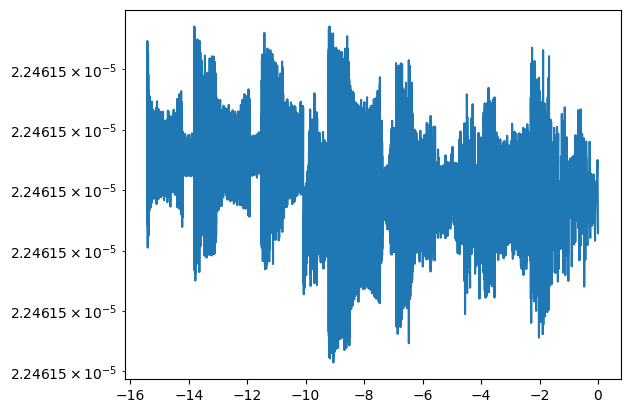

In [26]:
plt.plot(lna, abs(tau_c_class-tau_c_abcmb)/tau_c_class)
plt.yscale("log")
plt.show()